In [82]:
# rf

## Setup and preprocessing

In [83]:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tqdm import tqdm


In [84]:
# main data file
file_path = '../data/data.feather'

df = pd.read_feather(file_path)

data filtering

In [85]:
COLS_TH = 60

In [86]:
# Calculate percentage of missing values per column
missing_percentage = df.isnull().mean() * 100

# Calculate total number of missing values
total_missing = df.isnull().sum().sum()

# Calculate percentage of missing values in entire dataset
total_missing_percentage = (total_missing / df.size) * 100

# Display statistics
print("Percentage of missing values per column:")
print(missing_percentage)
print("\nTotal number of missing values:", total_missing)
print("Total cells: ", df.shape[0]*df.shape[1])
print(f"\nPercentage of missing values in entire dataset: {total_missing_percentage:.2f}%")

Percentage of missing values per column:
q2             63.670270
q11            57.789121
q12            67.097161
q13            52.346755
q14            54.473388
                 ...    
gender          2.933992
race           18.936391
gender2         3.223589
gender2_num     3.223589
CA_items        0.000000
Length: 2625, dtype: float64

Total number of missing values: 137897961
Total cells:  179473875

Percentage of missing values in entire dataset: 76.83%


In [87]:
# Select columns where the percentage of missing values is greater than COLS_TH%
full_cols = missing_percentage[missing_percentage < COLS_TH].index

# Display these columns
subset = df[full_cols]

subset = subset.replace('nan', pd.NA)  # Convert string 'nan' to actual NaN

In [88]:
ROWS_TH = 10

In [89]:
# drop rows with more than ROWS_TH empty

In [90]:
# Calculate percentage of missing values per row
missing_percent_rows = subset.isnull().mean(axis=1) *100

# Keep only rows with less than or equal to ROWS_TH% missing values
df_cleaned = subset.loc[missing_percent_rows <= ROWS_TH, :]

In [91]:
df_cleaned.shape

(19236, 394)

In [92]:
assert any(col.startswith('p_') for col in df_cleaned.columns), "No columns start with 'p_'"

onehot

In [93]:
df_cleaned_encoded = pd.get_dummies(df_cleaned, dummy_na=True, prefix_sep='_')
display(df_cleaned_encoded)

,p_pure,d_age,p_sexdrive,lf_max_age,p_oldfash,p_sprit,lf_min_age,CA,gender2_num,CA_items,...,race_Black,race_Other,race_Indian,race_Middle Eastern,race_Native American,race_Pacific Islander,race_nan,gender2_Man,gender2_Woman,gender2_nan
25,-74.0,30.0,57.0,38.0,NaN,-29.0,21.0,0.730555,1.0,5.0,...,False,False,False,False,False,False,False,True,False,False
39,-23.0,24.0,4.0,35.0,NaN,-9.0,24.0,1.246493,0.0,9.0,...,False,False,False,False,False,False,False,False,True,False
109,NaN,28.0,NaN,32.0,NaN,-37.0,23.0,0.287568,1.0,6.0,...,False,False,False,False,False,False,False,True,False,False
176,-3.0,38.0,81.0,60.0,NaN,NaN,21.0,-0.787995,1.0,7.0,...,False,False,False,False,False,False,True,True,False,False
255,-74.0,38.0,39.0,35.0,-32.0,-38.0,25.0,1.067317,1.0,10.0,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67778,NaN,25.0,NaN,35.0,-45.0,NaN,22.0,0.920521,1.0,5.0,...,False,False,False,False,False,False,False,True,False,False
67783,NaN,31.0,NaN,42.0,NaN,-6.0,25.0,1.246493,1.0,9.0,...,False,False,False,False,False,False,False,True,False,False
67813,NaN,22.0,-49.0,38.0,25.0,7.0,18.0,-2.423662,1.0,1.0,...,False,False,False,False,False,False,False,True,False,False
67840,-23.0,24.0,NaN,40.0,NaN,-4.0,18.0,2.008814,1.0,3.0,...,False,False,False,False,False,False,False,True,False,False


imputation

In [94]:
# df_cleaned_encoded_sampled  = df_cleaned_encoded.sample(n=1000, random_state=42)

In [103]:
df_cleaned_encoded.shape

(19236, 5525)

In [95]:
# Run the imputation
df_imputed = df_cleaned_encoded.copy()
numeric_cols = df_imputed.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = df_imputed.select_dtypes(include=['object', 'category']).columns

# Numerical imputation
if len(numeric_cols) > 0:
    print("Imputing numerical columns...")
    num_imputer = KNNImputer(n_neighbors=2)
    df_imputed[numeric_cols] = num_imputer.fit_transform(df_imputed[numeric_cols])

# Categorical imputation
if len(categorical_cols) > 0:
    label_encoders = {}
    for col in tqdm(categorical_cols, desc="Encoding Progress"):
        le = LabelEncoder().fit(df_imputed[col].dropna())
        label_encoders[col] = le
        df_imputed[col] = df_imputed[col].map(
            lambda x: le.transform([x])[0] if pd.notna(x) else np.nan
        )

    print("Imputing categorical columns...")
    cat_imputer = KNNImputer(n_neighbors=2)
    df_imputed[categorical_cols] = cat_imputer.fit_transform(df_imputed[categorical_cols])

    for col in tqdm(categorical_cols, desc="Decoding Progress"):
        le = label_encoders[col]
        max_label = len(le.classes_) - 1
        df_imputed[col] = df_imputed[col].round().clip(0, max_label).astype(int)
        df_imputed[col] = df_imputed[col].map(
            lambda x: le.inverse_transform([x])[0]
        )

print("Imputed DataFrame:\n", df_imputed)

Imputing numerical columns...
Imputed DataFrame:
        p_pure  d_age  p_sexdrive  lf_max_age  p_oldfash  p_sprit  lf_min_age  \
25      -74.0   30.0        57.0        38.0        0.0    -29.0        21.0   
39      -23.0   24.0         4.0        35.0       -9.5     -9.0        24.0   
109      22.5   28.0        -6.5        32.0       13.0    -37.0        23.0   
176      -3.0   38.0        81.0        60.0        4.5    -11.0        21.0   
255     -74.0   38.0        39.0        35.0      -32.0    -38.0        25.0   
...       ...    ...         ...         ...        ...      ...         ...   
67778   -27.0   25.0         7.0        35.0      -45.0     29.5        22.0   
67783   -75.0   31.0        13.0        42.0      -35.0     -6.0        25.0   
67813   -72.0   22.0       -49.0        38.0       25.0      7.0        18.0   
67840   -23.0   24.0        24.0        40.0       -5.5     -4.0        18.0   
67858    -0.5   26.0       -12.5        40.0       71.0     65.0      

## pca run

In [96]:
df_cleaned_imputed_no_p = df_imputed.loc[:, ~df_imputed.columns.str.startswith('p_')]


In [97]:
# Step 1: Standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_cleaned_imputed_no_p)

# Step 2: Apply PCA
pca = PCA(n_components=2)  # Specify number of components or use None to keep all
df_pca = pca.fit_transform(df_scaled)

# Step 3: Create a DataFrame with PCA results
df_pca_result = pd.DataFrame(df_pca, columns=['PC1', 'PC2'])

# Step 4: Check explained variance
print("Explained variance ratio:", pca.explained_variance_ratio_)

# Optional: View the PCA-transformed data
print(df_pca_result)

Explained variance ratio: [0.00826578 0.00461688]
             PC1        PC2
0      10.290461   2.110031
1       5.998819  -9.101765
2       6.093060  -5.255526
3      -0.202405  11.907051
4      12.132389   0.515576
...          ...        ...
19231   4.321674  -0.288358
19232   0.954401  -6.755888
19233 -10.779685  -1.523915
19234   6.072814  -5.605924
19235   6.228502 -10.851946

[19236 rows x 2 columns]


In [98]:
cols_df_imputed = df_imputed.columns.tolist()
cols_df_cleaned_imputed_no_p = df_cleaned_imputed_no_p.columns.tolist()
unused_cols = list(set(cols_df_imputed) - set(cols_df_cleaned_imputed_no_p))

print(unused_cols)

['p_sexdrive', 'p_oldfash', 'p_sprit', 'p_pure']


In [100]:
from sklearn.metrics import silhouette_score

# Step 1: Evaluate each unused column
silhouette_scores = {}

for col in unused_cols:
    # Get labels from the column
    if df_imputed[col].dtype in [int, float]:
        # Bin numerical columns into discrete groups (e.g., quartiles)
        labels = pd.qcut(df_imputed[col], q=4, duplicates='drop', labels=False)
    else:
        # Use categorical values directly
        labels = df_imputed[col].astype('category').cat.codes

    # Calculate silhouette score (requires at least 2 unique labels)
    if len(np.unique(labels)) > 1:
        score = silhouette_score(df_pca, labels)
        silhouette_scores[col] = score
    else:
        silhouette_scores[col] = -1  # Invalid if only one group

# Step 2: Find the best column
print("Silhouette Scores (higher is better):")
for col, score in silhouette_scores.items():
    print(f"{col}: Silhouette Score = {score:.3f}")

best_col = max(silhouette_scores, key=silhouette_scores.get)
print(f"Best column for clustering: {best_col}")


Silhouette Scores (higher is better):
p_sexdrive: Silhouette Score = -0.012
p_oldfash: Silhouette Score = -0.017
p_sprit: Silhouette Score = -0.056
p_pure: Silhouette Score = -0.030
Best column for clustering: p_sexdrive


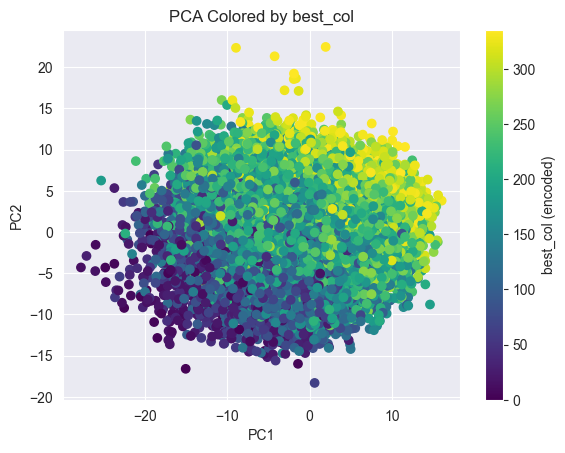

In [102]:
import matplotlib.pyplot as plt

# Assuming df_pca_result and df_cleaned_imputed_no_p are already defined from your code
# Step 5: Visualize PCA with column "X" as color
plt.scatter(df_pca_result['PC1'], df_pca_result['PC2'],
            c=df_imputed[best_col].astype('category').cat.codes,
            cmap='viridis')
plt.title('PCA Colored by best_col')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='best_col (encoded)')
plt.show()